## Siamese Neural Networks 
### for Supervised Clustering of High Dimensional Spaces

In [1]:
!python -V
!which python

Python 3.8.5
/Users/seanmacrae/mobius/.venv/bin/python


In [2]:
import pandas as pd

# DOWNLOAD DATSET HERE: https://www.kaggle.com/nehaprabhavalkar/av-healthcare-analytics-ii
los = pd.read_csv("data/train_data.csv")

print(los.shape)
los.head()

(318438, 18)


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [3]:
# import seaborn as sns

# sns.pairplot(los, hue='Stay')

In [4]:
from sklearn.model_selection import train_test_split

los_sample, _ = train_test_split(
    los,
    test_size=0.98,
    stratify=los["Stay"])

los_sample.shape

(6368, 18)

## Tabular Learner

Before we train the Tabular Siamese Learner we will train baseline Tabular Learner for species classification... (why do we do this, exactly? can we just instantiate a Tabular Siamese Learner without a baseline Tabular Learner ???)

Ah yes, to init a new `TabularSiameseModel` we need to provide an `encoder` and `head` and the Tabular Learner will act as the `encoder` we init the `TabularSiameseModel` with.

In [5]:
from sklearn.model_selection import train_test_split

# los_train, los_val = train_test_split(
#     los,
#     test_size=0.10,
#     stratify=los["Stay"])

los_train, los_val = train_test_split(
    los_sample,
    test_size=0.10,
    stratify=los_sample["Stay"])

los_train.shape, los_val.shape

df = los_train.copy()

exclude_vars = ["case_id", "patientid"]

In [6]:
from fastai.tabular.all import CategoryBlock
                                
# y_names = ["species"]
y_names = ["Stay"]
y_block = CategoryBlock()

In [7]:
from mobius.utils import emb_sz_rule

cat_names = [x for x in df.select_dtypes(exclude=['int', 'float']).columns if x != y_names]
cat_names = [x for x in cat_names if x not in exclude_vars]

# calc embedding sizes for each categorical feature
emb_szs = {k: emb_sz_rule(len(df[k].unique())) for k in cat_names}
emb_szs

{'Hospital_type_code': 5,
 'Hospital_region_code': 3,
 'Department': 4,
 'Ward_Type': 4,
 'Ward_Facility_Code': 4,
 'Type of Admission': 3,
 'Severity of Illness': 3,
 'Age': 6,
 'Stay': 6}

In [8]:
import numpy as np

cont_names = [x for x in df.select_dtypes([np.number]).columns if x != y_names]
cont_names = [x for x in cont_names if x not in exclude_vars]
cont_names

['Hospital_code',
 'City_Code_Hospital',
 'Available Extra Rooms in Hospital',
 'Bed Grade',
 'City_Code_Patient',
 'Visitors with Patient',
 'Admission_Deposit']

In [9]:
from fastai.tabular.all import (Categorify, CategoryBlock, FillMissing,
                                Normalize, TabDataLoader, TabularPandas,
                                tabular_config, tabular_learner)

procs = [FillMissing, Categorify, Normalize]

In [10]:
from fastai.data.core import range_of
from fastai.tabular.all import RandomSplitter

# train/test split
splits = RandomSplitter(valid_pct=0.10)(range_of(df))

In [11]:
tabular_pandas = TabularPandas(
        df,
        procs=procs,
        cat_names=cat_names,
        cont_names=cont_names,
        y_names=y_names,
        y_block=y_block,
        splits=splits,
        device="cpu")

In [12]:
trn_dl = TabDataLoader(
    tabular_pandas.train,
    bs=128,
    shuffle=True,
    drop_last=True,
    num_workers=4)

val_dl = TabDataLoader(
    tabular_pandas.valid,
    bs=128,
    num_workers=4)

In [13]:
from fastai.data.core import DataLoaders

dls = DataLoaders(trn_dl, val_dl)

print("Sample batch:")
# dls.one_batch()

Sample batch:


In [14]:
from fastai.metrics import F1Score, Precision, Recall, accuracy

# load the tabular_pandas data through the tabular_learner
layers = [2048, 1024, 32, 2]

# tabular learner configuration
config = tabular_config(ps=[0.2, 0.1, 0.1, 0.0], embed_p=0.1)

learn = tabular_learner(
    dls,
    layers=layers,
    emb_szs=emb_szs,
    config=config,
    metrics=[accuracy,
             Precision(average='macro'),
             Recall(average='macro'),
             F1Score(average='macro')])

In [15]:
learn.fit_one_cycle(n_epoch=1)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.950629,2.140342,0.389180,0.175551,0.236054,0.183456,00:03


/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
# learn.export("tabular_learn.pkl")

In [17]:
# from mobius.calibration import ModelWithTemperature

# scaled_model = ModelWithTemperature(learn.model)
# scaled_model.set_temperature(val_dl)
# learn.model = scaled_model.model

In [18]:
# true species labels
y_true=learn.dls.valid.items["Stay"]

# model scores and species predictions
y_scores, *_ = learn.get_preds(dl=val_dl)
preds = np.argmax(y_scores, 1).numpy()

/Users/seanmacrae/mobius/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
print("First 20 species labels and predictions")
list(zip(y_true, preds))[:10]

First 20 species labels and predictions


[(5, 5),
 (1, 1),
 (2, 6),
 (4, 6),
 (0, 6),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1)]

In [20]:
(y_true == preds).sum() / len(y_true)

0.38917975567190227

## Siamese Net

To init a new `TabularSiameseDataset` object, we only need a `tabular_pandas` object from the fast.ai library.

In [ ]:
from mobius.datasets import write_jsonl

# write SNN training data to `data/`
write_jsonl(tabular_pandas.train.to.items[0].items, "data/train_data.jsonl")
write_jsonl(tabular_pandas.valid.to.items[0].items, "data/valid_data.jsonl")

# write SNN training labels to `data/`
tabular_pandas.train.y.to_csv("data/train_labels.csv", index=True)
tabular_pandas.valid.y.to_csv("data/valid_labels.csv", index=True)

In [21]:
from mobius.datasets import TabularSiameseDataset

train_ds = TabularSiameseDataset(
    csv_file="data/train_labels.csv", 
    jsonl_file="data/train_data.jsonl",
    tabular_learner=learn)
    
valid_ds = TabularSiameseDataset(
    csv_file="data/valid_labels.csv", 
    jsonl_file="data/valid_data.jsonl",
    tabular_learner=learn)

In [22]:
train_ds.__len__(), train_ds.__getitem__(1)

(5158,
 ((tensor([5, 1, 3, 2, 5, 2, 2, 4, 1, 1, 1]),
   tensor([ 0.7874, -1.1998,  0.7111,  0.4040,  0.5821, -0.7020, -0.2164])),
  (tensor([7, 2, 3, 4, 2, 1, 3, 2, 6, 1, 1]),
   tensor([ 0.4407,  1.3594, -0.1605,  0.4040,  1.4345, -0.7020, -1.7210])),
  tensor(1.)))

In [23]:
valid_ds.__len__(), valid_ds.__getitem__(0)

(573,
 ((tensor([1, 3, 1, 3, 6, 1, 3, 6, 2, 1, 1]),
   tensor([-0.5994,  0.0798, -1.0322,  1.5586, -0.2702, -0.1585,  0.5616])),
  (tensor([1, 1, 3, 2, 6, 1, 3, 5, 1, 1, 1]),
   tensor([ 0.5563,  0.3997,  1.5827, -1.9051, -0.0571, -0.1585, -0.4982])),
  tensor(1.)))

In [ ]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=16, device='cpu', num_workers=2)

Siamese net encoder is the body of the Tabular net we just trained.

In [ ]:
dls.dataset.c

In [ ]:
import copy

encoder = copy.copy(learn)
encoder.model.layers = learn.model.layers[:-1]
encoder_model = encoder.model

In [ ]:
from fastai.layers import LinBnDrop

head = LinBnDrop(n_in=layers[-1]*2,
    n_out=16,  # size of output space
    bn=True,
    act=None)

In [24]:
import time
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from fastai.callback.core import Callback


# TODO: save every TSNE model as pkl - interactive 3-d w/ tooltip to show point information (id, features, etc.)
class TSNECallback(Callback):
    def after_validate(self):
        plt.clf()
        t = int(time.time())
        train_encoded = list()
        for i in range(len(siamese_learner.dls.valid.dataset.labels)):
            p, _, _ = siamese_learner.dls.valid_ds.__getitem__(i)

            # rehsape into mini-batch size 1
            p = p[0].reshape(1, -1), p[1].reshape(1, -1)

            # encode the household into output embedding space
            p_encode = siamese_learner.model.encode(p)
            train_encoded.append(p_encode)
            
        ids = self.dls.valid.get_idxs()
        y_train_labels = self.dls.valid.dataset.labels["Stay"]
        train_encoded_df = pd.DataFrame(torch.stack(train_encoded).squeeze())

        # write encoded space to csv
        train_encoded_df.to_csv(f"tsne_{t}_{self.epoch}.csv")
        
        # limit the permutation of hyper-params of t-SNE
        tsne = TSNE(n_components=2, metric="euclidean", n_iter=500)
        encoded_train_tsne = tsne.fit_transform(train_encoded_df.values)
        np.save(f"tsne_{t}_{self.epoch}.npy", encoded_train_tsne)
        
        # TODO: add title...
        sns.scatterplot(x=encoded_train_tsne[:,0],
                        y=encoded_train_tsne[:,1],
                        hue=y_train_labels, 
                        legend=False, 
                        palette="tab10").figure.savefig(f"snn_{t}_epoch_{self.epoch}.png")
        
        
# TODO: run knn on embedding space to show learned embedding is informative!!!

In [ ]:
from mobius.models import TabularSiameseModel

model = TabularSiameseModel(encoder_model, head)

In [ ]:
from fastai.torch_basics import params
from mobius.losses import ContrastiveLoss

def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

def contrastive_loss_func(out, targ):
    return ContrastiveLoss(margin=0.50)(out, targ.long())

In [ ]:
from fastai.learner import Learner

siamese_learner = Learner(dls,
    model,
    model_dir=".",
    loss_func=contrastive_loss_func,
    splitter=siamese_splitter,
    cbs=[TSNECallback])

In [ ]:
# y_labels = siamese_learner.dls.valid.dataset.labels["Stay"]
# y_labels.to_csv("y_labels.csv")

In [ ]:
# %debug
# siamese_learner.summary()

In [ ]:
# siamese_learner.freeze()
# siamese_learner.fit(n_epoch=3, lr=10e-4)

In [ ]:
siamese_learner.unfreeze()
siamese_learner.fit(n_epoch=3, lr=10e-3)

In [ ]:
siamese_learner.fit(n_epoch=3, lr=10e-4)

In [ ]:
# TODO: inspect margin, using log space grid search - .01, .1, .5, .75, 1., 10., 50. - hypothesis is that the margin is too low and space is collapsging
# TODO: inspect the LR manually - smaller learning rates - maybe fix learning rate across grid search; maybe use lr_min / 2 ?

In [25]:
learning_rates = [10e-3, 10e-4, 10e-5]
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
margins = [0.001, 0.01, 0.1, 1, 10, 20, 50, 100]
head_out = [16, 32, 64, 128]

lr = 0.01, batch size = 16, margin = 0.001, n_out = 16


KeyboardInterrupt: 

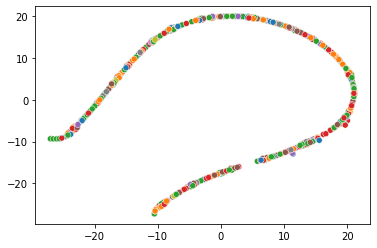

In [26]:
import copy
from fastai.layers import LinBnDrop
from fastai.learner import Learner
from mobius.models import TabularSiameseModel
from fastai.torch_basics import params
from mobius.losses import ContrastiveLoss

def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

for lr in learning_rates:
    for batch_size in batch_sizes:
        for margin in margins:
            for n_out in head_out:
                print(f"lr = {lr}, batch size = {batch_size}, margin = {margin}, n_out = {n_out}")
                # create batch size
                dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=batch_size, device='cpu', num_workers=2)

                # create new encoder model
                encoder = copy.copy(learn)
                encoder.model.layers = learn.model.layers[:-1]
                encoder_model = encoder.model

                # create new head
                head = LinBnDrop(n_in=layers[-1]*2,
                n_out=n_out,  # size of output space
                bn=True,
                act=None)

                # create new model
                model = TabularSiameseModel(encoder_model, head)
                
                # set margin
                def contrastive_loss_func(out, targ):
                    return ContrastiveLoss(margin=margin)(out, targ.long())

                # create new learner
                siamese_learner = Learner(dls,
                    model,
                    model_dir=f"batch{batch_size}_margin{margin}_nout{n_out}",
                    loss_func=contrastive_loss_func,
                    splitter=siamese_splitter,
                    cbs=[TSNECallback])
                
                # fit learner
                siamese_learner.unfreeze()
                siamese_learner.fit(n_epoch=5, lr=lr)
                siamese_learner.save(f"snn_learner")